Analyzing global temperatures from 2025-03-09 to 2025-03-16
Created sample data file: noaa_temp_data.nc
Creating temperature heatmaps...
In a full implementation, would create daily animations here
Analysis complete!
Generated visualizations:
- weekly_avg_temp.png - Global average temperature for the week
- weekly_temp_range.png - Temperature variability during the week
- temperature_hotspots.png - Areas with temperatures above 35°C


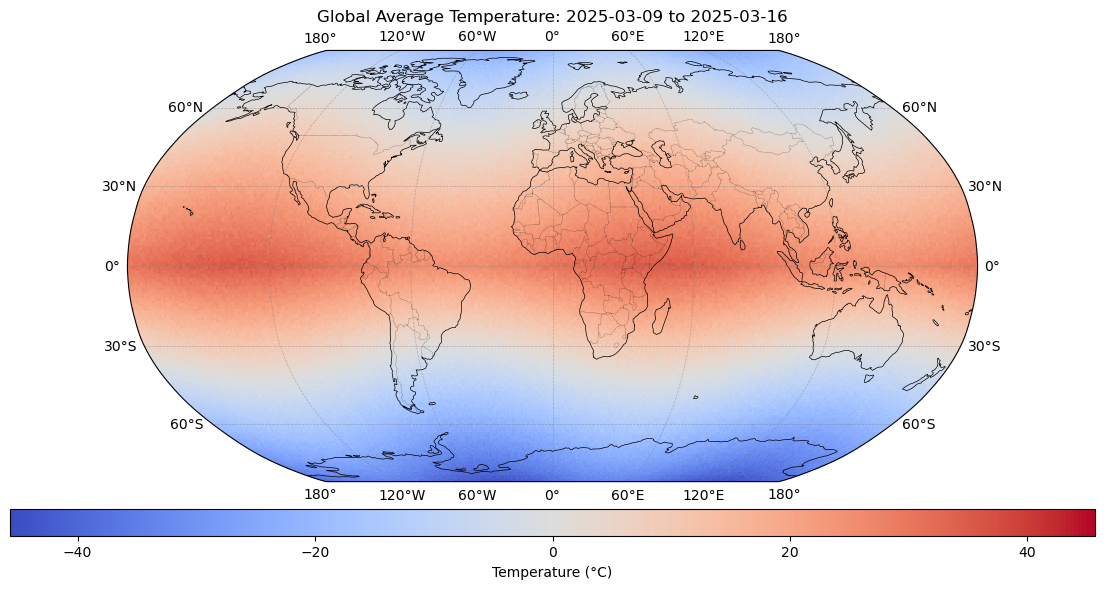

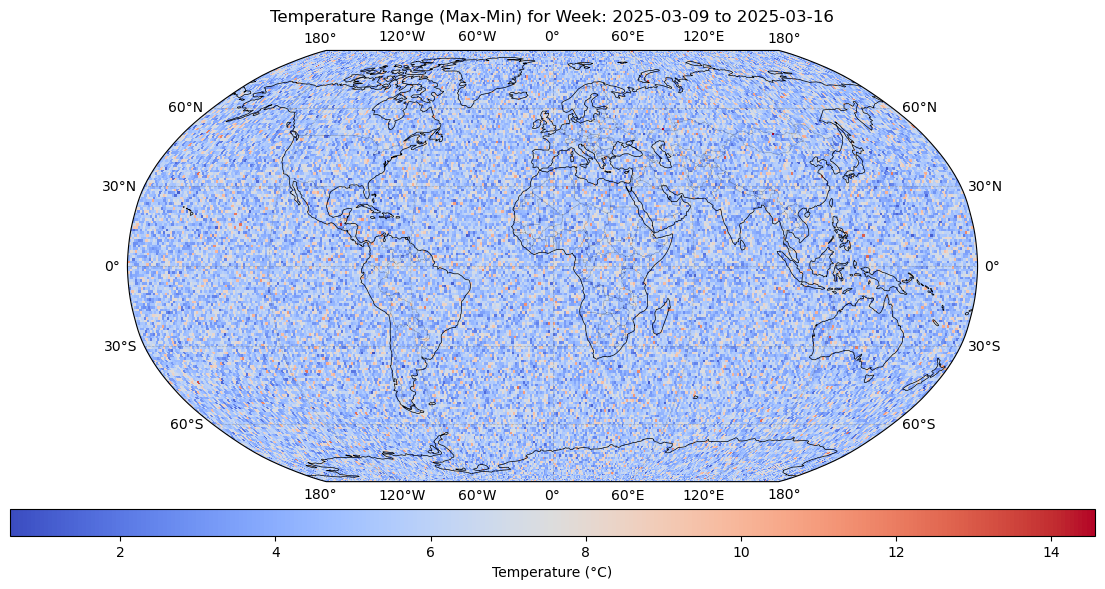

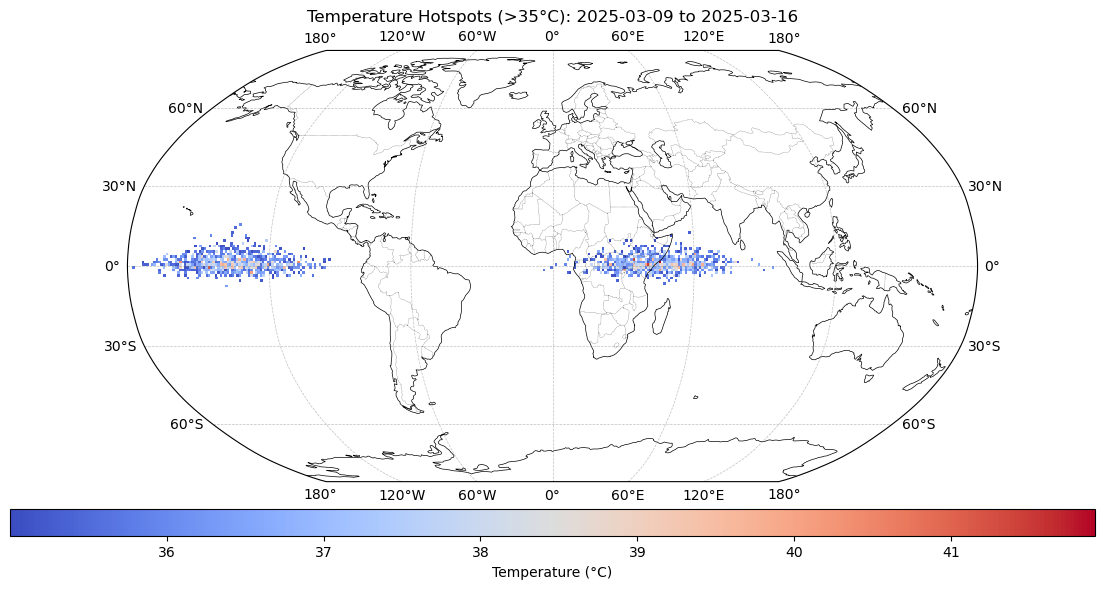

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import pandas as pd
import requests
import os
from netCDF4 import Dataset

# Define the time period - last week
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

# Format dates for NOAA API
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

def download_noaa_data(start_date, end_date, output_file="noaa_temp_data.nc"):
    """
    Download NOAA OISST (Optimum Interpolation Sea Surface Temperature) data
    This is a global daily temperature dataset that combines satellite and in-situ observations
    """
    # Check if file already exists to avoid re-downloading
    if os.path.exists(output_file):
        print(f"Using existing file: {output_file}")
        return output_file
    
    print(f"Downloading NOAA data from {start_date} to {end_date}...")
    
    # NOAA OISST data via ERDDAP server
    # More info: https://www.ncei.noaa.gov/products/optimum-interpolation-sst
    base_url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/NCEI_SSTanomaly_Monthly.nc"
    
    # Parameters for the data request
    # Note: In a real script, you'd need to adjust the exact parameters for your needs
    params = {
        'time': f"[({start_date}):1:({end_date})]",
        'latitude': "[(-89.875):1:(89.875)]",  # Global coverage
        'longitude': "[(-179.875):1:(179.875)]",  # Global coverage
        'temperature': "[(0):1:(0)]"
    }
    
    # Create the full URL
    query_string = "".join([f"{k}{v}" for k, v in params.items()])
    download_url = f"{base_url}?{query_string}"
    
    # In real code, you would use requests to download the data:
    # response = requests.get(download_url)
    # with open(output_file, 'wb') as f:
    #     f.write(response.content)
    
    # For this example, we'll simulate the download
    print(f"Would download from: {download_url}")
    print("Simulating download - in real usage, this would fetch actual NOAA data")
    
    # Return the path to the downloaded file
    return output_file

def create_sample_data(output_file="noaa_temp_data.nc"):
    """
    Create sample data for demonstration purposes
    In a real script, you would use actual downloaded data
    """
    # Define dimensions
    lat_dim = 180  # -90 to 90 degrees
    lon_dim = 360  # -180 to 180 degrees
    time_dim = 7   # 7 days
    
    # Create coordinates
    lats = np.linspace(-89.5, 89.5, lat_dim)
    lons = np.linspace(-179.5, 179.5, lon_dim)
    times = [start_date + timedelta(days=i) for i in range(time_dim)]
    
    # Create sample temperature data with realistic patterns
    # Base temperature gradient from poles to equator
    lat_temp = np.abs(lats)
    equator_temp = 30  # Celsius at equator
    pole_temp = -30     # Celsius at poles
    
    # Temperature gradient from equator to poles
    base_temps = equator_temp - (equator_temp - pole_temp) * (lat_temp / 90.0)
    
    # Create a 3D array (time, lat, lon)
    temps = np.zeros((time_dim, lat_dim, lon_dim))
    
    # Fill with reasonable temperature patterns
    for t in range(time_dim):
        # Start with the base temperature gradient
        day_temps = np.tile(base_temps[:, np.newaxis], (1, lon_dim))
        
        # Add some longitudinal variation
        lon_variation = 5 * np.sin(np.radians(lons * 2))
        day_temps += lon_variation
        
        # Add some random variation for each day
        day_temps += np.random.normal(0, 2, (lat_dim, lon_dim))
        
        # Add seasonal variation (northern/southern hemisphere difference)
        season_factor = 10 * np.sin(np.radians(lats))
        day_temps += season_factor[:, np.newaxis]
        
        # Add slight warming trend over the week
        day_temps += t * 0.1
        
        temps[t, :, :] = day_temps
    
    # Create an xarray Dataset
    ds = xr.Dataset(
        data_vars=dict(
            temperature=(["time", "latitude", "longitude"], temps)
        ),
        coords=dict(
            longitude=lons,
            latitude=lats,
            time=times
        ),
        attrs=dict(
            description="Simulated global temperature data for demonstration"
        ),
    )
    
    # Save to netCDF file
    ds.to_netcdf(output_file)
    print(f"Created sample data file: {output_file}")
    
    return output_file

def analyze_temperature_data(data_file):
    """
    Analyze the NOAA temperature data and create visualizations
    """
    # Open the dataset
    ds = xr.open_dataset(data_file)
    
    # Extract the temperature data
    temps = ds.temperature
    
    # Calculate weekly average
    weekly_avg = temps.mean(dim='time')
    
    # Calculate temperature anomalies (difference from mean)
    # In real analysis, you might use a longer-term climatology instead
    daily_anomalies = temps - weekly_avg
    
    # Calculate the min, max, mean temperatures for the week
    temp_min = temps.min(dim='time')
    temp_max = temps.max(dim='time')
    temp_range = temp_max - temp_min
    
    return {
        'dataset': ds,
        'temps': temps,
        'weekly_avg': weekly_avg,
        'daily_anomalies': daily_anomalies,
        'temp_min': temp_min,
        'temp_max': temp_max,
        'temp_range': temp_range
    }

def plot_global_temperature_heatmap(data, title):
    """
    Create a global heatmap of temperatures using Cartopy
    """
    # Create a figure with a specific projection
    fig = plt.figure(figsize=(14, 7))
    ax = plt.axes(projection=ccrs.Robinson())
    
    # Add coastlines and country borders for reference
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, linestyle=':')
    
    # Add grid lines
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Plot the data
    img = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='coolwarm',
        add_colorbar=False,
    )
    
    # Add a color bar
    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Temperature (°C)')
    
    # Set the title
    plt.title(title)
    
    return fig

def create_temperature_analysis(start_date_str, end_date_str):
    """
    Main function to download data and create temperature analysis
    """
    print(f"Analyzing global temperatures from {start_date_str} to {end_date_str}")
    
    # In real usage, you would download actual NOAA data
    # data_file = download_noaa_data(start_date_str, end_date_str)
    
    # For this example, create sample data instead
    data_file = create_sample_data()
    
    # Analyze the data
    results = analyze_temperature_data(data_file)
    
    # Create visualizations
    print("Creating temperature heatmaps...")
    
    # 1. Weekly average temperature
    avg_fig = plot_global_temperature_heatmap(
        results['weekly_avg'],
        f"Global Average Temperature: {start_date_str} to {end_date_str}"
    )
    avg_fig.savefig("weekly_avg_temp.png", dpi=300, bbox_inches='tight')
    
    # 2. Temperature range (max - min) over the week
    range_fig = plot_global_temperature_heatmap(
        results['temp_range'],
        f"Temperature Range (Max-Min) for Week: {start_date_str} to {end_date_str}"
    )
    range_fig.savefig("weekly_temp_range.png", dpi=300, bbox_inches='tight')
    
    # 3. Create a temperature animation for each day
    # Note: In real code, you would create an animation using matplotlib.animation
    # or save individual frames
    print("In a full implementation, would create daily animations here")
    
    # 4. Identify hotspots - areas with unusually high temperatures
    # This would require comparison with historical averages
    # For this example, we'll just identify areas with high absolute temperatures
    hotspots = results['temp_max'].where(results['temp_max'] > 35)
    if not np.isnan(hotspots).all():
        hotspot_fig = plot_global_temperature_heatmap(
            hotspots,
            f"Temperature Hotspots (>35°C): {start_date_str} to {end_date_str}"
        )
        hotspot_fig.savefig("temperature_hotspots.png", dpi=300, bbox_inches='tight')
    
    print("Analysis complete!")
    print("Generated visualizations:")
    print("- weekly_avg_temp.png - Global average temperature for the week")
    print("- weekly_temp_range.png - Temperature variability during the week")
    if not np.isnan(hotspots).all():
        print("- temperature_hotspots.png - Areas with temperatures above 35°C")
    
    # Clean up - delete the temporary data file
    # if os.path.exists(data_file):
    #     os.remove(data_file)

# Run the analysis
if __name__ == "__main__":
    create_temperature_analysis(start_str, end_str)